In [1]:
library(Rcpp)
library(RcppArmadillo)
sourceCpp("model/NMFspatial.cpp")

# load the data count
count = read.csv('data/LH_counts.csv', header = T)
count = as.matrix(count)
count = count[,-1]

location = read.csv('data/LH_location.csv')
location = location[,-1]
location = as.matrix(location)

genes = colnames(count)

In [2]:
n = nrow(location)

X = location
X2 = rowSums(X^2)
X2 = matrix(X2, nrow = length(X2), ncol = length(X2), byrow = F)
dist = sqrt(X2 - 2*X%*%t(X) + t(X2))


#save(dist, file = 'LH_distmat.RData')

In [6]:
sigma = exp(-0.01*dist)
sigma[sigma < 0.2] = 0
sigma = sigma/rowSums(sigma)

mean(rowSums(sigma >0))
min(rowSums(sigma >0))

[1] 15.04592

[1] 1

In [5]:
sum(rowSums(sigma >0) == 2)

[1] 37

In [15]:
data = count
data = data/rowSums(data)


out = nmfspatial(data, 10,weight = sigma, initial = 1, smallIter = 100, maxiter = 1000)

In [41]:
save(out, file = "modelssaved/LH1000_l0005.RData")

In [16]:
load("modelssaved/LH5K_l0005.RData")

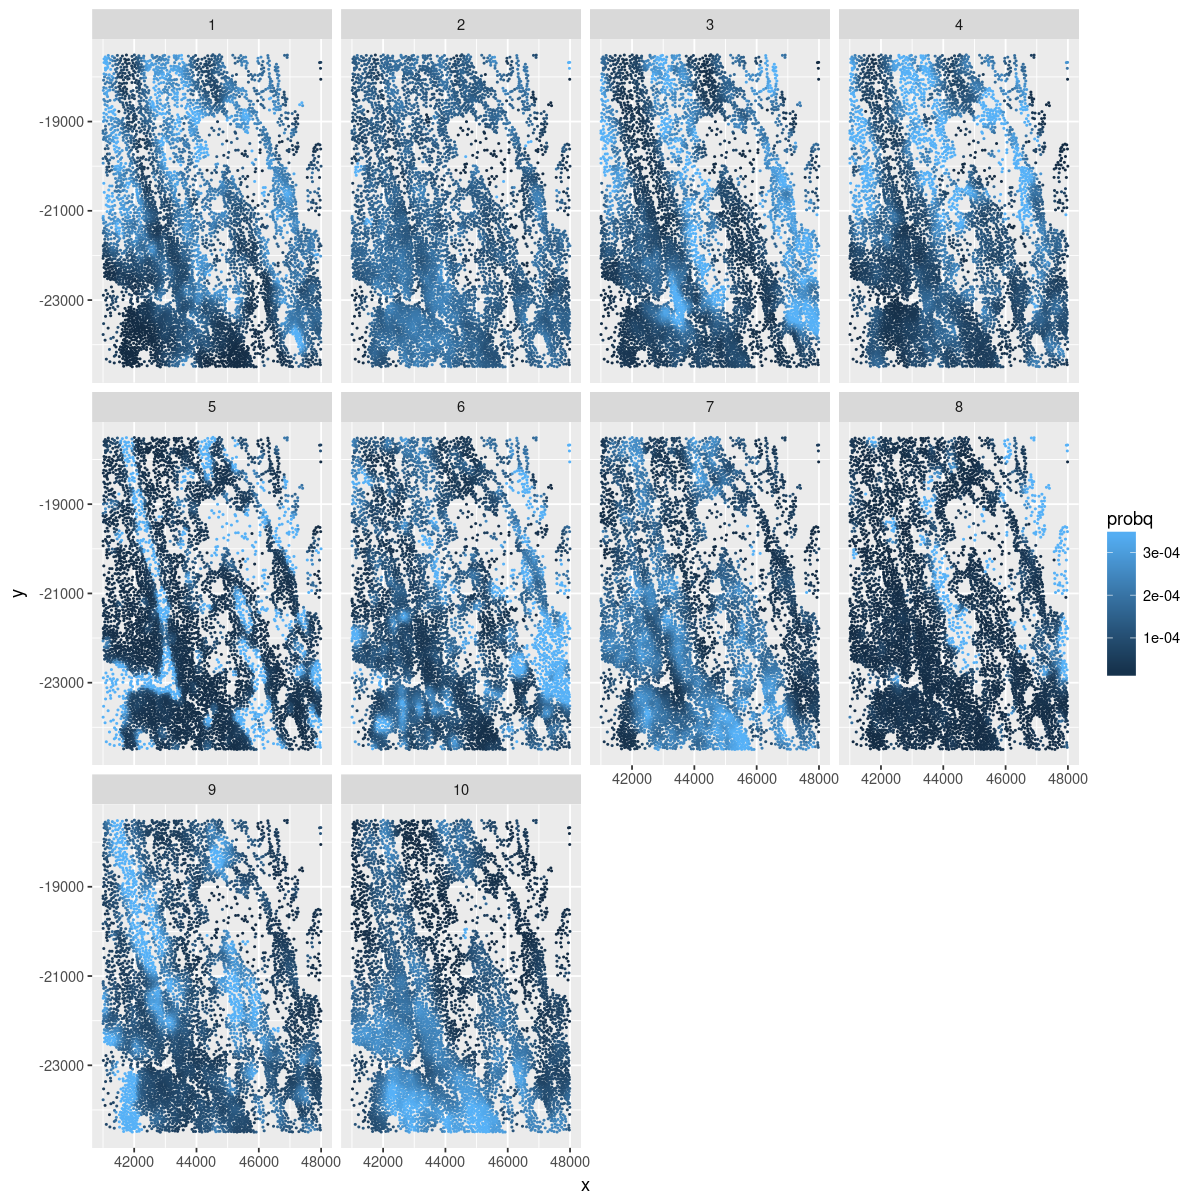

In [17]:
library(ggplot2)
plotdat = data.frame(x = location[,1], y = location[,2], all = t(t(out$exposures)/colSums(out$exposures)))

datalong = reshape(plotdat, varying = colnames(plotdat)[-c(1,2)], direction = 'long', v.names = "prob")
options(repr.plot.width=10, repr.plot.height=10)
datalong$probq = datalong$prob
qmax = quantile(datalong$probq, 0.95)
datalong$probq[datalong$prob > qmax] = qmax
ggplot(datalong, aes(x = x, y = y, col = probq))+
        geom_point(cex = 0.2)+
        #geom_point(cex = 0.5, alpha = 0.2)+
        #scale_colour_viridis()+
        facet_wrap(~time)



In [10]:
# TF-IDF function
dat = out$signatures
TF = dat/rowSums(dat)
IDF = log(ncol(count)/colSums(count>0))

TFIDFtopic = TF*IDF

In [129]:
## weight the genes in the signatures with weighting
dat = t(out$signatures)
dat_new=NULL
for(ii in 1:nrow(dat)){
  rr=dat[ii,]
  m1=max(rr)
  m2=max(rr[-which(rr==m1)])
  mm=rep(m1, length(rr))
  mm[which(rr==m1)]=m2
  ns=rr*log((rr+1)/(mm+1))
  dat_new=rbind(dat_new, ns)
}


dim(dat_new)

[1] 492  10

In [165]:
topgenes = NULL
ng = 20
for(topic in 1:10){
    idx = order(out$signatures[topic,], decreasing = T)
    original = genes[idx[1:ng]]
    idx = order(TFIDFtopic[topic,], decreasing = T)
    TFIDF = genes[idx[1:ng]]
    idx = order(dat_new[,topic], decreasing = T)
    weighting = genes[idx[1:ng]]
    xdata = rbind(original,TFIDF,weighting)
    xdata = cbind(topic,xdata)
    topgenes = rbind(topgenes,xdata)
    print(xdata)
}

write.csv(topgenes, "topic_topgenes.csv")

          topic                                                                
original  "1"   "PKM" "NDUFA4L2" "CA9"  "MYC"  "EPCAM"  "LDHA"  "CDKN1A" "YAP1"
TFIDF     "1"   "CA9" "EPCAM"    "YAP1" "FOS"  "SMAD2"  "PLOD2" "XBP1"   "JUNB"
weighting "1"   "PKM" "NDUFA4L2" "CA9"  "LDHA" "CDKN1A" "YAP1"  "BCL2L1" "XBP1"
                                                                          
original  "XBP1" "ITGB1" "BCL2L1" "NFE2L2" "IDH1"  "BAK1" "SMAD2" "FOS"   
TFIDF     "MYC"  "CEBPB" "FZD7"   "IFNGR2" "HRAS"  "LDHA" "DDIT3" "PMS2"  
weighting "BAK1" "IDH1"  "SMAD2"  "VEGFB"  "PLOD2" "HRAS" "KRAS"  "NFE2L2"
                                          
original  "PLOD2" "LMNA"   "HDAC1" "JUNB" 
TFIDF     "MAFB"  "TNC"    "NRAS"  "MMRN1"
weighting "LMNA"  "MAP2K1" "FZD7"  "EGF"  
          topic                                                            
original  "2"   "EPCAM" "HLA.B" "CDH1"  "LRP1"  "HLA.DRA"  "ERBB3" "JUN"   
TFIDF     "2"   "CDH1"  "JUN"   "TAPBP" "LAMB3" "HLA.DRB

In [6]:
# plot seperately
plots = list()
for(i in 1:ncol(out$exposures)){
    plotdat = data.frame(x = location[,1], y = location[,2], prob = t(t(out$exposures[,i])/sum(out$exposures[,i])))
    qmax = quantile(plotdat$prob, 0.95)
    plotdat$prob[plotdat$prob > qmax] = qmax
    plots[[i]] = ggplot(plotdat, aes(x = x, y = y, col = prob))+
        geom_point(cex = 1)
}

#save(plots,file ="topic_plots.RData")

In [7]:
library(ggpubr)

ERROR: Error in library(ggpubr): there is no package called ‘ggpubr’
